In [17]:
#import sys
#sys.path.append('../')
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Galactocentric


import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)

from streamsculptor import potential
from streamsculptor import JaxCoords as jc




In this example we will integrate orbits in a custom time-dependent potential function. 
All we need to supply is the potential: Jax will take care of its derivatives via automatic differentiation.


The potential function we will define is a time-dependent NFW

$$\Phi_{\rm osc}\left(\mathbf{r}, t\right) = -\frac{G M(t)}{r^\prime} \ln{\left(1 + \frac{r^\prime}{r_s(t)}\right)}$$
with the functions
$$M(t) = M_{\rm base} + M_{\rm osc}\sin\left(\Omega t\right)$$
$$r_s(t) = r_{s,\rm base} + r_{s, \rm osc}\sin\left(\Omega t\right)$$
$$r^\prime = \sqrt{x^2 + y^2 + \left(\frac{z}{q(t)}\right)^2}$$
$$q(t) = 1 + 0.3 \times \cos{\left(\Omega t\right)}$$




In [4]:
from astropy.constants import G
## Define the grav. constant in the simulation unit system [kpc, Myr, Msun]
G_ = G.decompose(usys).value
M_base = 1e12 #Msun
M_osc = 5e11
rs_base = 15.0 #kpc
rs_osc = 10.0
T = 500.0 #Myr
omega = 2*jnp.pi / T

## Define the oscilatting potential function
@jax.jit
def osc_potential_func(xyz, t):
    xyz = jnp.array([xyz[0], xyz[1], xyz[2]/(1 + 0.3*jnp.cos(omega*t))])
    r = jnp.sqrt(jnp.sum(xyz**2))

    curr_mass = M_base + M_osc*jnp.sin(omega*t)
    rs_curr = rs_base + rs_osc*jnp.sin(omega*t)
    return - (G_*curr_mass / r)*jnp.log(1 + r/rs_curr)
    
## Define its static counterpart
@jax.jit
def static_potential_func(xyz, t):
    r = jnp.sqrt(jnp.sum(xyz**2))
    curr_mass = M_base 
    rs_curr = rs_base 
    return - (G_*curr_mass / r)*jnp.log(1 + r/rs_curr)

In [7]:
potential.CustomPotential

streamsculptor.potential.CustomPotential

In [12]:
## Import the CustomPotential class
from streamsculptor.potential import CustomPotential

In [13]:
## Create the CustomPotential objects. All we need to do is tell 
## the CustomPotential object what the potential function is. Jax will take care of the rest.
pot_osc = CustomPotential(potential_func=osc_potential_func, units=usys)
pot_static = CustomPotential(potential_func=static_potential_func, units=usys)

In [14]:
## Compute potential at different times –– should be different:
xyz = jnp.array([1.0, 20.0, 10.0])
print(pot_osc.potential(xyz,-1000.0),pot_osc.potential(xyz,-850.0)) 


-0.186204177133592 -0.19132325459167931


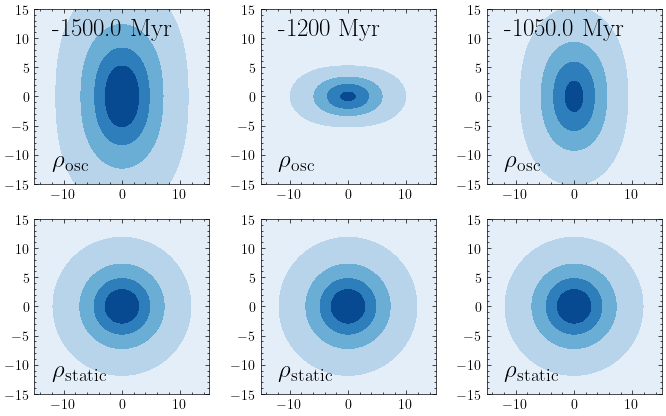

In [18]:
## Let's visualize the density of both potentials, by taking the Laplacian of the potential using autodiff
x_grid = jnp.linspace(-15, 15, 100)
z_grid = jnp.linspace(-15, 15, 100)
X, Z = jnp.meshgrid(x_grid, z_grid)
inp = jnp.array([X.flatten(), jnp.zeros_like(X.flatten())+5.0, Z.flatten()]).T 

## Time dep case:
t1, t2, t3 = -1500.0, -1200, -1050.0
## Most basic functions in StreamSculptor assume a 1D input.
## But we can still evalaute over many inputs using the vmap (vectorized map) functionality from Jax
## The syntax is batch_function = jax.vmap(function, in_axes=(tuple of axes to map over))
dens_t1 = jax.vmap(pot_osc.density,in_axes=(0,None))(inp, t1).reshape(X.shape)
dens_t2 = jax.vmap(pot_osc.density,in_axes=(0,None))(inp, t2).reshape(X.shape)
dens_t3 = jax.vmap(pot_osc.density,in_axes=(0,None))(inp, t3).reshape(X.shape)

## Static case:
dens_static = jax.vmap(pot_static.density,in_axes=(0,None))(inp, 0.0).reshape(X.shape)

## Visualize
fig, ax = plt.subplots(2,3, figsize=(10,5))

ax[0,0].contourf(X,Z,dens_t1,levels=4,cmap='Blues')
ax[0,1].contourf(X,Z,dens_t2,levels=4,cmap='Blues')
ax[0,2].contourf(X,Z,dens_t3,levels=4,cmap='Blues')

for i in range(3):
    ax[1,i].contourf(X,Z,dens_static,levels=4,cmap='Blues')
    ax[0,i].text(0.1,0.85,f'{[t1,t2,t3][i]}' + " Myr",transform=ax[0,i].transAxes,fontsize=18)
    ax[0,i].text(0.1,0.1, r"$\rho_{\rm osc}$",transform=ax[0,i].transAxes,fontsize=18)
    ax[1,i].text(0.1,0.1, r"$\rho_{\rm static}$",transform=ax[1,i].transAxes,fontsize=18)
ax_flat = ax.flatten()

for i in range(6):
    ax_flat[i].set_aspect('equal')  

fig.subplots_adjust(wspace=-0.3,hspace=0.2)



In [19]:
## now integrate some orbits
w0 = jnp.array([10.0, 10.0, 15.0, 0.1, 0.2, 0.1])
ts = jnp.linspace(-4000,0,1000)
orb_osc = pot_osc.integrate_orbit(w0=w0,ts=ts).ys
orb_static = pot_static.integrate_orbit(w0=w0,ts=ts).ys

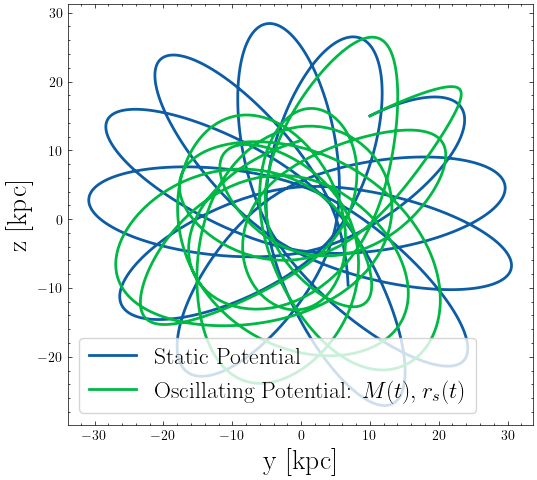

In [20]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
ax.plot(orb_static[:,1],orb_static[:,2], label='Static Potential',lw=2)
ax.plot(orb_osc[:,1],orb_osc[:,2],label=r'Oscillating Potential: $M(t), r_s(t)$',lw=2)

ax.legend(fontsize=17,loc='lower left',frameon=True)
ax.set_xlabel('y [kpc]', fontsize=20)
ax.set_ylabel('z [kpc]', fontsize=20)

ax.set_aspect('equal')


In [21]:
## Now generate a stream in both potentials
## First set the stripping times for each arm:
ts = jnp.linspace(-3000,0,1000) #uniform from -3000 Myr to present day (0.0)
## Get initial conditions, such that the final location of the progenitor is the same (at t = 0)
IC_osc = pot_osc.integrate_orbit(w0=w0,t0=0, t1=-3000.0, ts=jnp.array([-3000])).ys[0]
IC_static = pot_static.integrate_orbit(w0=w0,t0=0, t1=-3000.0, ts=jnp.array([-3000])).ys[0]

## Generate streams in oscillating and static potentials
lead, trail = pot_osc.gen_stream_scan(prog_w0=IC_osc, ts=ts,Msat=1e4,seed_num=3932)
stream_osc = jnp.vstack([lead,trail])

lead, trail = pot_static.gen_stream_scan(prog_w0=IC_static, ts=ts,Msat=1e4,seed_num=3932)
stream_static = jnp.vstack([lead,trail])

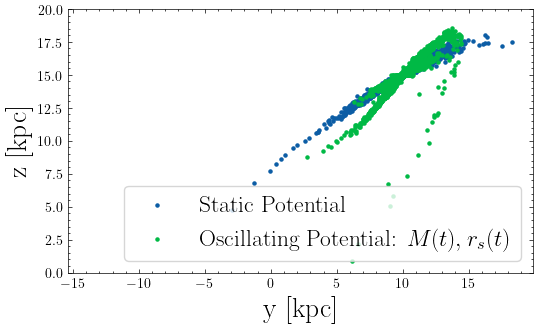

In [22]:
## Visualize the output
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)

ax.scatter(stream_static[:,1],stream_static[:,2],label='Static Potential',s=5)
ax.scatter(stream_osc[:,1],stream_osc[:,2],label=r'Oscillating Potential: $M(t), r_s(t)$',s=5)

lgnd = ax.legend(fontsize=17,loc='lower right',frameon=True,)


ax.set_xlabel('y [kpc]', fontsize=20)
ax.set_ylabel('z [kpc]', fontsize=20)
ax.set_ylim(0,20)
ax.set_aspect('equal')